Trabalho para matéria de Métodos para Análise de grande volume de dados e Astroinformática

Por Diogo Ayres Rocha 

In [ ]:
!pip install healpy

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
import numpy as np
import healpy as hp
import pandas as pd
import os
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import glob
from PIL import Image
from google.colab import drive # Comentar se for rodar localmente no computador

In [ ]:
# Comentar as duas proximas linhas se for rodar localmente no computador
drive.mount('/content/drive')
%cd /content/drive/My Drive/ 

freqs       = [30, 44, 70, 100, 143, 217, 353, 545, 857] # Frequências dos mapas dispoíveis da colaboração
FitsFolder  = "./Fits"
filesList   = os.listdir(FitsFolder)
print(filesList)
FitsList    = []
for freq in freqs:
    for file in filesList:
        if (str(freq) in file):
            FitsList.append(os.path.join(FitsFolder,file))
            break
        elif ("CMB" in file):
            CMBFile = os.path.join(FitsFolder,file)
            continue

In [ ]:
# Carregando CMB e plotando
img = hp.fitsfunc.read_map(CMBFile, nest=True)
hp.mollview(img, title="CMB plot", nest=True)
plt.show(block=False)
plt.tight_layout()
plt.savefig('PlanckMaps_CMB.png')
plt.close()

<ipython-input-59-1e7ee5872065>:3: RuntimeWarning: invalid value encountered in log
  hp.mollview(np.log(img), title="CMB plot [LOG Scale]", nest=True)


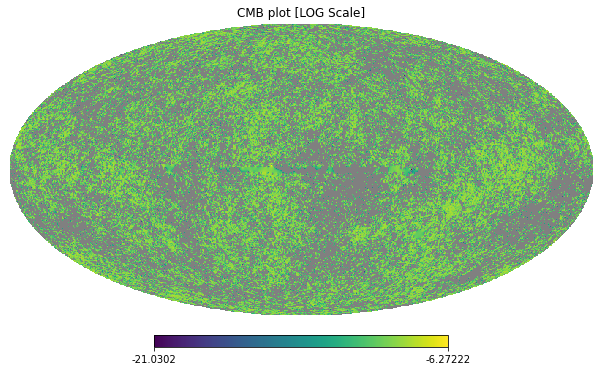

In [ ]:
# Carregando CMB e plotando [Escala Logarítmica]
img = hp.fitsfunc.read_map(CMBFile, nest=True)
hp.mollview(np.log(img), title="CMB plot [LOG Scale]", nest=True)
plt.show(block=False)
plt.tight_layout()
plt.savefig('PlanckMaps_CMB_LOG.png')
plt.close()

In [ ]:
# Carregando Mapas de frequência e plotando em um único canvas
fig,  ([ax0, ax1, ax2], [ax3, ax4, ax5], [ax6, ax7, ax8]) = plt.subplots(nrows=3, ncols=3, figsize=(1920/600, 1080/600), dpi=600)
for i, file in enumerate(FitsList):
    img = hp.fitsfunc.read_map(file, nest=True)
    eval("plt.axes(ax%d)"%(i))
    hp.mollview(img, title="Temp Flutuation for Freq=%dGHz"%(freqs[i]), nest=True, hold=True)
    plt.show(block=False)
plt.savefig('PlanckMaps.png')
plt.close()

In [ ]:
# Carregando Mapas de frequência e plotando em um único canvas [Escala Logarítmica]
fig,  ([ax0, ax1, ax2], [ax3, ax4, ax5], [ax6, ax7, ax8]) = plt.subplots(nrows=3, ncols=3, figsize=(1920/600, 1080/600), dpi=600)
for i, file in enumerate(FitsList):
    img = hp.fitsfunc.read_map(file, nest=True)
    eval("plt.axes(ax%d)"%(i))
    hp.mollview(np.log(img), title="Temp Flutuation for Freq=%dGHz [LOG Scale]"%(freqs[i]), nest=True, hold=True)
    plt.show(block=False)
plt.savefig('PlanckMaps_LOG.png') 
plt.close()

In [ ]:
# Análise de uma região selecionada com K-Means (região com picos bem definidos)
i           = 0
OutFolderName = 'FREQ%d_-5-lat-5_10-long-20'%(freqs[i])
try:
    !mkdir "PartMapAnalysis_KMEANS"     # Para rodar no google colab
    #os.mkdir("PartMapAnalysis_KMEANS") # Para rodar localmente no computador
except:
    print('Folder \"PartMapAnalysis_KMEANS\" already exists...')
try:
    !mkdir 'PartMapAnalysis_KMEANS/'$OutFolderName                  # Para rodar no google colab
    #os.mkdir(os.path.join('PartMapAnalysis_KMEANS',OutFolderName)) # Para rodar localmente no computador
except:
    print('Folder \"'+OutFolderName+'\" already exists...')
img         = hp.fitsfunc.read_map(FitsList[i], nest=True)    
nside       = hp.pixelfunc.npix2nside(len(img)) # Obtendo o NSide a partir do número de pixels dos mapas
thetaLoc    = [1.4834457030421433, 1.6581469505476498]
phiLoc      = [0.17410681942502026, 0.3489806292439833]
theta, phi  = hp.fitsfunc.pixelfunc.pix2ang(nside,np.arange(len(img)), nest=True) # Obtendo o Theta e Phi a partir do pixel (ra = phi | 90 - dec = theta)
d           = {'theta': theta, 'phi': phi, 'I': img.byteswap().newbyteorder()}
df          = pd.DataFrame(data=d)
df_sliced   = df[(df.theta > thetaLoc[0]) & (df.theta < thetaLoc[1]) & (df.phi > phiLoc[0]) & (df.phi < phiLoc[1])]
# Obtendo o número de clusters ótimo da partir da curva:
Sum_of_squared_distances = []
K = range(1,25)
for k in K:
    kmeans  = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, max_iter = 300)
    Clusters  = kmeans.fit_predict(df_sliced.values)
    Sum_of_squared_distances.append(kmeans.inertia_)
    fig2    = plt.figure()
    ax      = fig2.add_subplot(projection='3d')
    p       = ax.scatter(df_sliced.theta.values, df_sliced.phi.values, df_sliced.I.values, c = Clusters, marker='o')
    plt.colorbar(p, shrink=0.5)
    plt.title('%d Clusters - Freq=%dGHz - %.2f<Theta<%.2f - %.2f<Phi<%.2f '%(k,freqs[i],thetaLoc[0],thetaLoc[1],phi[0],phi[1]))
    ax.set_xlabel('Theta')
    ax.set_ylabel('Phi')
    ax.set_zlabel('I')
    plt.tight_layout()
    plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'Part_%dClustersFreq%d_%.2ftheta%.2f_%.2fphi%.2f.png'%(k,freqs[i],thetaLoc[0],thetaLoc[1],phi[0],phi[1])))
    plt.show(block=False)
    plt.close()
    fig3,  ([ax0, ax1]) = plt.subplots(nrows=1, ncols=2)
    plt.axes(ax0)
    hp.cartview(np.log(img), title="Temp Flutuation for Freq=%dGHz [LOG Scale]"%(freqs[i]), latra=[-5,5], lonra=[10,20], nest=True, hold=True)
    plt.axes(ax1)
    df["clusters"]=np.ones(len(img))*(-1)
    for pos in range(len(df_sliced)):
        df.clusters[df_sliced[pos:pos+1:].index[0]]=Clusters[pos]
    hp.cartview(df.clusters.values, title="%d Clusters for Freq=%dGHz"%(k,freqs[i]), latra=[-5,5], lonra=[10,20], nest=True, hold=True)
    fig3.get_children()[1].get_children()[8].set_fontsize(7)
    fig3.get_children()[3].get_children()[8].set_fontsize(7)
    plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'Part_%dClustersFreq%d_%.2ftheta%.2f_%.2fphi%.2f_ComparisonView.png'%(k,freqs[i],thetaLoc[0],thetaLoc[1],phi[0],phi[1])))
    plt.show()
    print("\nClusters criados pelo K-Means para NClusters=%d\n"%(k))
    print(kmeans.cluster_centers_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal K')
plt.show(block=False)
plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'elbow_part_Freq%d_-5lat5_10long20.png'%(freqs[i])))
plt.close()

In [ ]:
# Análise da mesma região com DBScan
i           = 0
try:
    !mkdir 'PartMapAnalysis_DBScan'     # Para rodar no google colab
    #os.mkdir('PartMapAnalysis_DBScan') # Para rodar localmente no computador
except:
    print('Folder \"PartMapAnalysis_DBScan\" already exists...')
OutFolderName = 'FREQ%d_-5-lat-5_10-long-20'%(freqs[i])
try:
    !mkdir 'PartMapAnalysis_DBScan/'$OutFolderName                   # Para rodar no google colab
    #os.mkdir(os.path.join('PartMapAnalysis_DBScan',OutFolderName))  # Para rodar localmente no computador
except:
    print('Folder \"'+OutFolderName+'\" already exists...')
img         = hp.fitsfunc.read_map(FitsList[i], nest=True)    
nside       = hp.pixelfunc.npix2nside(len(img)) # Obtendo o NSide a partir do número de pixels dos mapas
thetaLoc    = [1.4834457030421433, 1.6581469505476498]
phiLoc      = [0.17410681942502026, 0.3489806292439833]
theta, phi  = hp.fitsfunc.pixelfunc.pix2ang(nside,np.arange(len(img)), nest=True) # Obtendo o Theta e Phi a partir do pixel (ra = phi | 90 - dec = theta)
d           = {'theta': theta, 'phi': phi, 'I': img.byteswap().newbyteorder()}
df          = pd.DataFrame(data=d)
df_sliced   = df[(df.theta > thetaLoc[0]) & (df.theta < thetaLoc[1]) & (df.phi > phiLoc[0]) & (df.phi < phiLoc[1])]
neighbors = NearestNeighbors(n_neighbors=12)
neighbors_fit       = neighbors.fit(df_sliced.values)
distances, indices  = neighbors_fit.kneighbors(df_sliced.values)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title('Elbow Method for Freq=%d'%(freqs[i]))
f = plt.gcf()
f.get_children()[1].set_xlabel("Data points")
f.get_children()[1].set_ylabel("Average distances")
plt.savefig(os.path.join('PartMapAnalysis_DBScan',OutFolderName,'Elbow_Distances_DBScan_Freq%d.png'%(freqs[i])))
plt.show(block=False)
plt.close()
for epsVal in [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004]:
    for min_samplesVal in [6, 12]:
        clustering      = DBSCAN(eps=epsVal, min_samples=min_samplesVal).fit(df_sliced.values)
        DBSCAN_dataset  = df_sliced.copy()
        DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_ 
        fig2    = plt.figure()
        ax      = fig2.add_subplot(projection='3d')
        p       = ax.scatter(DBSCAN_dataset.theta.values, DBSCAN_dataset.phi.values, DBSCAN_dataset.I.values, c = DBSCAN_dataset.Cluster.values, marker='o')
        plt.colorbar(p, shrink=0.5)
        plt.title('eps=%.4f - minSamples=%d - Freq=%dGHz'%(epsVal, min_samplesVal, freqs[i]))
        ax.set_xlabel('Theta')
        ax.set_ylabel('Phi')
        ax.set_zlabel('I')
        plt.tight_layout()			
        plt.savefig(os.path.join('PartMapAnalysis_DBScan',OutFolderName,'Part_eps%.4f_MinSamples%d_Freq%d.png'%(epsVal, min_samplesVal, freqs[i])))
        plt.show(block=False) 
        plt.close()
        fig3,  ([ax0, ax1]) = plt.subplots(nrows=1, ncols=2)
        plt.axes(ax0)
        hp.cartview(np.log(img), title="Temp Flutuation for Freq=%dGHz [LOG Scale]"%(freqs[i]), latra=[-5,5], lonra=[10,20], nest=True, hold=True)
        plt.axes(ax1)
        df["clusters"]=np.ones(len(img))*(-1)
        for pos in range(len(df_sliced)):
            df.clusters[df_sliced[pos:pos+1:].index[0]]=DBSCAN_dataset.Cluster.values[pos]
        hp.cartview(df.clusters.values, title="eps%.4f MinSamples%d for Freq=%dGHz"%(epsVal, min_samplesVal, freqs[i]), latra=[-5,5], lonra=[10,20], nest=True, hold=True)
        fig3.get_children()[1].get_children()[8].set_fontsize(7)
        fig3.get_children()[3].get_children()[8].set_fontsize(7)
        plt.savefig(os.path.join('PartMapAnalysis_DBScan',OutFolderName,'Part_eps%.4f_MinSamples%d_Freq%d_ComparisonView.png'%(epsVal, min_samplesVal, freqs[i])))
        plt.show(block=False)

In [ ]:
# Análise de todos os mapas de frequência em partes
for i, file in enumerate(FitsList):
    # Varrendo o espaço de pi/16 em pi/16 para theta e phi com 1% de margem para evitar efeito de bordas
    for thetaVal in range(0,16):
        for phiVal in range (0,32):
            # Obtendo os limites de theta e phi
            ThetaL  = (0.99*thetaVal*np.pi)/16
            ThetaH  = (1.01*(thetaVal+1)*np.pi)/16
            PhiL    = (0.99*phiVal*np.pi)/16
            PhiH    = (1.01*(phiVal+1)*np.pi)/16
            OutFolderName = 'FREQ%d_%.2f-Theta-%.2f_%.2f-Phi-%.2f'%(freqs[i],ThetaL,ThetaH,PhiL,PhiH)
            try:
                !mkdir 'PartMapAnalysis_KMEANS/'$OutFolderName                  # Para rodar no google colab
                #os.mkdir(os.path.join('PartMapAnalysis_KMEANS',OutFolderName)) # Para rodar localmente no computador
            except:
                print('Folder \"'+OutFolderName+'\" already exists...')
            img     = hp.fitsfunc.read_map(FitsList[i], nest=True)    
            nside   = hp.pixelfunc.npix2nside(len(img)) # Obtendo o NSide a partir do número de pixels dos mapas
            theta, phi  = hp.fitsfunc.pixelfunc.pix2ang(nside,np.arange(len(img)), nest=True) # Obtendo o Theta e Phi a partir do pixel (ra = phi | 90 - dec = theta)
            d       = {'theta': theta, 'phi': phi, 'I': img.byteswap().newbyteorder()}
            df      = pd.DataFrame(data=d)
            df_sliced   = df[(df.theta > ThetaL) & (df.theta < ThetaH) & (df.phi > PhiL) & (df.phi < PhiH)]
            # Obtendo o número de clusters ótimo da partir da curva:
            Sum_of_squared_distances = []
            K = range(1,30)
            for k in K:
                kmeans  = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, max_iter = 300)
                Clusters  = kmeans.fit_predict(df_sliced.values)
                Sum_of_squared_distances.append(kmeans.inertia_)
                fig2    = plt.figure()
                ax      = fig2.add_subplot(projection='3d')
                p       = ax.scatter(df_sliced.theta.values, df_sliced.phi.values, df_sliced.I.values, c = Clusters, marker='o')
                plt.colorbar(p, shrink=0.5)
                plt.title('%d Clusters - Freq=%dGHz - %.2f<Theta<%.2f - %.2f<Phi<%.2f '%(k,freqs[i],ThetaL,ThetaH,PhiL,PhiH))
                ax.set_xlabel('Theta')
                ax.set_ylabel('Phi')
                ax.set_zlabel('I')
                plt.tight_layout()
                plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'Part_%dClustersFreq%d_%.2ftheta%.2f_%.2fphi%.2f.png'%(k,freqs[i],ThetaL,ThetaH,PhiL,PhiH)))
                plt.show(block=False)   
                plt.close()
                fig3,  ([ax0, ax1]) = plt.subplots(nrows=1, ncols=2)
                plt.axes(ax0)
                hp.mollview(np.log(img), title="Temp Flutuation for Freq=%dGHz [LOG Scale]"%(freqs[i]), nest=True, hold=True)
                plt.axes(ax1)
                df["clusters"]=np.ones(len(img))*(-1)
                for pos in range(len(df_sliced)):
                    df.clusters[df_sliced[pos:pos+1:].index[0]]=Clusters[pos]
                hp.mollview(df.clusters.values, title="%d Clusters for Freq=%dGHz"%(k,freqs[i]), nest=True, hold=True)
                fig3.get_children()[1].get_children()[8].set_fontsize(7)
                fig3.get_children()[3].get_children()[8].set_fontsize(7)
                plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'Part_%dClustersFreq%d_%.2ftheta%.2f_%.2fphi%.2f_ComparisonView.png'%(k,freqs[i],ThetaL,ThetaH,PhiL,PhiH)))
                plt.show(block=False)
                print("\nClusters criados pelo K-Means para NClusters=%d\n"%(k))
                print(kmeans.cluster_centers_)
                # Para ativar o parâmetro abaixo, mudar o range do número de clusters para começar em 2
                #silhouette_avg = silhouette_score(df_sliced.values, Clusters)
                #print("Para n_clusters =", k,"\nO score_silhouette médio é :", silhouette_avg)
            plt.plot(K, Sum_of_squared_distances, 'bx-')
            plt.xlabel('Number of Clusters K')
            plt.ylabel('Sum of squared distances')
            plt.title('Elbow Method For Optimal K')
            plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'elbow_part_Freq%d__%.2ftheta%.2f_%.2fphi%.2f.png'%(freqs[i],ThetaL,ThetaH,PhiL,PhiH)))
            plt.show(block=False)
            plt.close()

In [ ]:
# Análise do mapa de CMB em partes
# Varrendo o espaço de pi/16 em pi/16 para theta e phi com 1% de margem para evitar efeito de bordas
for thetaVal in range(0,16):
    for phiVal in range (0,32):
        img         = hp.fitsfunc.read_map(CMBFile, nest=True)
        nside       = hp.pixelfunc.npix2nside(len(img)) # Obtendo o NSide a partir do número de pixels dos mapas
        theta, phi  = hp.fitsfunc.pixelfunc.pix2ang(nside,np.arange(len(img)), nest=True) # Obtendo o Theta e Phi a partir do pixel (ra = phi | 90 - dec = theta)
        d       = {'theta': theta, 'phi': phi, 'I': img.byteswap().newbyteorder()}
        df      = pd.DataFrame(data=d)
        # Obtendo os limites de theta e phi
        ThetaL  = (0.99*thetaVal*np.pi)/16
        ThetaH  = (1.01*(thetaVal+1)*np.pi)/16
        PhiL    = (0.99*phiVal*np.pi)/16
        PhiH    = (1.01*(phiVal+1)*np.pi)/16
        OutFolderName = 'CMB_%.2f-Theta-%.2f_%.2f-Phi-%.2f'%(ThetaL,ThetaH,PhiL,PhiH)
        try:
            !mkdir 'PartMapAnalysis_KMEANS/'$OutFolderName                  # Para rodar no google colab
            #os.mkdir(os.path.join('PartMapAnalysis_KMEANS',OutFolderName)) # Para rodar localmente no computador
        except:
            print('Folder \"'+OutFolderName+'\" already exists...')
        df_sliced   = df[(df.theta > ThetaL) & (df.theta < ThetaH) & (df.phi > PhiL) & (df.phi < PhiH)]
        # Obtendo o número de clusters ótimo da partir da curva:
        Sum_of_squared_distances = []
        K = range(1,30)
        for k in K:
            kmeans  = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, max_iter = 300)
            Clusters  = kmeans.fit_predict(df_sliced.values)
            Sum_of_squared_distances.append(kmeans.inertia_)
            fig2    = plt.figure()
            ax      = fig2.add_subplot(projection='3d')
            p       = ax.scatter(df_sliced.theta.values, df_sliced.phi.values, df_sliced.I.values, c = Clusters, marker='o')
            plt.colorbar(p, shrink=0.5)
            plt.title('%d Clusters - CMB - %.2f<Theta<%.2f - %.2f<Phi<%.2f '%(k, ThetaL, ThetaH, PhiL, PhiH))
            ax.set_xlabel('Theta')
            ax.set_ylabel('Phi')
            ax.set_zlabel('I')
            plt.tight_layout()
            plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'Part_%dClusters_CMB_%.2ftheta%2f_%.2fphi%.2f.png'%(k, ThetaL, ThetaH, PhiL, PhiH)))
            plt.show(block=False)   
            plt.close()
            fig3,  ([ax0, ax1]) = plt.subplots(nrows=1, ncols=2)
            plt.axes(ax0)
            hp.mollview(np.log(img), title="Temp Flutuation for CMB [LOG Scale]", nest=True, hold=True)
            plt.axes(ax1)
            df["clusters"]=np.ones(len(img))*(-1)
            for pos in range(len(df_sliced)):
                df.clusters[df_sliced[pos:pos+1:].index[0]]=Clusters[pos]
            hp.mollview(df.clusters.values, title="%d Clusters for CMB"%(k), nest=True, hold=True)
            fig3.get_children()[1].get_children()[8].set_fontsize(7)
            fig3.get_children()[3].get_children()[8].set_fontsize(7)
            plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'Part_%dClusters_CMB_%.2ftheta%.2f_%.2fphi%.2f_ComparisonView.png'%(k,ThetaL,ThetaH,PhiL,PhiH)))
            plt.show(block=False)
            print("\nClusters criados pelo K-Means para NClusters=%d\n"%(k))
            print(kmeans.cluster_centers_)
            # Para ativar o parâmetro abaixo, mudar o range do número de clusters para começar em 2
            #silhouette_avg = silhouette_score(df_sliced.values, Clusters)
            #print("Para n_clusters =", k,"\nO score_silhouette médio é :", silhouette_avg)
        plt.plot(K, Sum_of_squared_distances, 'bx-')
        plt.xlabel('Number of Clusters K')
        plt.ylabel('Sum of squared distances')
        plt.title('Elbow Method For Optimal K')
        plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'elbow_part_CMB_%.2ftheta%2f_%.2fphi%.2f.png'%(ThetaL, ThetaH, PhiL, PhiH)))       
        plt.show(block=False)
        plt.close()

In [ ]:
# Fazendo clusterização com uso do DBScan em todos os mapas de frequência por partes
for i, file in enumerate(FitsList):
    img         = hp.fitsfunc.read_map(FitsList[i], nest=True)    
    nside       = hp.pixelfunc.npix2nside(len(img)) # Obtendo o NSide a partir do número de pixels dos mapas
    theta, phi  = hp.fitsfunc.pixelfunc.pix2ang(nside,np.arange(len(img)), nest=True) # Obtendo o Theta e Phi a partir do pixel (ra = phi | 90 - dec = theta)
    d   = {'theta': theta, 'phi': phi, 'I': img.byteswap().newbyteorder()}
    df  = pd.DataFrame(data=d)
    # Varrendo o espaço de pi/16 em pi/16 para theta e phi com 1% de margem para evitar efeito de bordas
    for thetaVal in range(0,16):
        for phiVal in range (0,32):
            # Obtendo os limites de theta e phi
            ThetaL    = (0.99*thetaVal*np.pi)/16
            ThetaH    = (1.01*(thetaVal+1)*np.pi)/16
            PhiL      = (0.99*phiVal*np.pi)/16
            PhiH      = (1.01*(phiVal+1)*np.pi)/16
            OutFolderName = 'FREQ%d_%.2f-Theta-%.2f_%.2f-Phi-%.2f'%(freqs[i],ThetaL,ThetaH,PhiL,PhiH)
            try:
                !mkdir 'PartMapAnalysis_DBScan/'$OutFolderName                  # Para rodar no google colab
                #os.mkdir(os.path.join('PartMapAnalysis_KMEANS',OutFolderName)) # Para rodar localmente no computador
            except:
                print('Folder \"'+OutFolderName+'\" already exists...')
            df_sliced = df[(df.theta > ThetaL) & (df.theta < ThetaH) & (df.phi > PhiL) & (df.phi < PhiH)]
            neighbors = NearestNeighbors(n_neighbors=12)
            neighbors_fit       = neighbors.fit(df_sliced.values)
            distances, indices  = neighbors_fit.kneighbors(df_sliced.values)
            distances = np.sort(distances, axis=0)
            distances = distances[:,1]
            plt.plot(distances)
            plt.title('Elbow Method for Freq=%d - %.2f < Theta > %.2f - %.2f < Phi > %.2f'%(freqs[i],ThetaL,ThetaH,PhiL,PhiH))
            plt.xlabel("Data points")
            plt.ylabel("Average distances")
            plt.savefig(os.path.join('PartMapAnalysis_DBScan/',OutFolderName,'Elbow_Distances_DBScan_Freq%d_%.2ftheta%2f_%.2fphi%.2f.png'%(freqs[i], ThetaL, ThetaH, PhiL, PhiH)))
            plt.show(block=False)
            plt.close()
            for epsVal in [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004]:
                for min_samplesVal in [6, 12]:
                    clustering      = DBSCAN(eps=epsVal, min_samples=min_samplesVal).fit(df_sliced.values)
                    DBSCAN_dataset  = df_sliced.copy()
                    DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_ 
                    fig2    = plt.figure()
                    ax      = fig2.add_subplot(projection='3d')
                    p       = ax.scatter(DBSCAN_dataset.theta.values, DBSCAN_dataset.phi.values, DBSCAN_dataset.I.values, c = DBSCAN_dataset.Cluster.values, marker='o')
                    plt.colorbar(p, shrink=0.5)
                    plt.title('eps=%.4f - minSamples=%d - Freq=%dGHz - %.2f < Theta > %.2f - %.2f < Phi > %.2f'%(epsVal, min_samplesVal, freqs[i],ThetaL,ThetaH,PhiL,PhiH))
                    ax.set_xlabel('Theta')
                    ax.set_ylabel('Phi')
                    ax.set_zlabel('I')
                    plt.tight_layout()			
                    plt.savefig(os.path.join('PartMapAnalysis_DBScan/',OutFolderName,'Part_eps%.4f_MinSamples%d_Freq%d_%.2ftheta%2f_%.2fphi%.2f.png'%(epsVal, min_samplesVal, freqs[i], ThetaL, ThetaH, PhiL, PhiH)))
                    plt.show(block=False) 
                    plt.close()

In [ ]:
# Fazendo clusterização com uso do DBScan no mapa de CMB por partes
img         = hp.fitsfunc.read_map(CMBFile, nest=True)    
nside       = hp.pixelfunc.npix2nside(len(img)) # Obtendo o NSide a partir do número de pixels dos mapas
theta, phi  = hp.fitsfunc.pixelfunc.pix2ang(nside,np.arange(len(img)), nest=True) # Obtendo o Theta e Phi a partir do pixel (ra = phi | 90 - dec = theta)
d   = {'theta': theta, 'phi': phi, 'I': img.byteswap().newbyteorder()}
df  = pd.DataFrame(data=d)
# Varrendo o espaço de pi/16 em pi/16 para theta e phi com 1% de margem para evitar efeito de bordas
for thetaVal in range(0,16):
    for phiVal in range (0,32):
        # Obtendo os limites de theta e phi
        ThetaL    = (0.99*thetaVal*np.pi)/16
        ThetaH    = (1.01*(thetaVal+1)*np.pi)/16
        PhiL      = (0.99*phiVal*np.pi)/16
        PhiH      = (1.01*(phiVal+1)*np.pi)/16
        OutFolderName = 'CMB_%.2f-Theta-%.2f_%.2f-Phi-%.2f'%(ThetaL,ThetaH,PhiL,PhiH)
        try:
            !mkdir 'PartMapAnalysis_DBScan/'$OutFolderName                  # Para rodar no google colab
            #os.mkdir(os.path.join('PartMapAnalysis_KMEANS',OutFolderName)) # Para rodar localmente no computador
        except:
            print('Folder \"'+OutFolderName+'\" already exists...')
        df_sliced = df[(df.theta > ThetaL) & (df.theta < ThetaH) & (df.phi > PhiL) & (df.phi < PhiH)]
        neighbors = NearestNeighbors(n_neighbors=12)
        neighbors_fit       = neighbors.fit(df_sliced.values)
        distances, indices  = neighbors_fit.kneighbors(df_sliced.values)
        distances = np.sort(distances, axis=0)
        distances = distances[:,1]
        plt.plot(distances)
        plt.title('Elbow Method for CMB - %.2f < Theta > %.2f - %.2f < Phi > %.2f'%(ThetaL,ThetaH,PhiL,PhiH))
        plt.xlabel("Data points")
        plt.ylabel("Average distances")
        plt.savefig(os.path.join('PartMapAnalysis_DBScan/',OutFolderName,'Elbow_Distances_DBScan_CMB_%.2ftheta%2f_%.2fphi%.2f.png'%(ThetaL, ThetaH, PhiL, PhiH)))
        plt.show(block=False)
        plt.close()
        for epsVal in [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004]:
            for min_samplesVal in [6, 12]:
                clustering      = DBSCAN(eps=epsVal, min_samples=min_samplesVal).fit(df_sliced.values)
                DBSCAN_dataset  = df_sliced.copy()
                DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_ 
                fig2    = plt.figure()
                ax      = fig2.add_subplot(projection='3d')
                p       = ax.scatter(DBSCAN_dataset.theta.values, DBSCAN_dataset.phi.values, DBSCAN_dataset.I.values, c = DBSCAN_dataset.Cluster.values, marker='o')
                plt.colorbar(p, shrink=0.5)
                plt.title('eps=%.4f - minSamples=%d - CMB - %.2f < Theta > %.2f - %.2f < Phi > %.2f'%(epsVal, min_samplesVal, ThetaL,ThetaH,PhiL,PhiH))
                ax.set_xlabel('Theta')
                ax.set_ylabel('Phi')
                ax.set_zlabel('I')
                plt.tight_layout()			
                plt.savefig(os.path.join('PartMapAnalysis_DBScan/',OutFolderName,'Part_eps%.4f_MinSamples%d_CMB_%.2ftheta%2f_%.2fphi%.2f.png'%(epsVal, min_samplesVal, ThetaL, ThetaH, PhiL, PhiH)),fontsize=7)
                plt.show(block=False) 
                plt.close()

In [ ]:
# Análise do mapa de CMB mapa completo
try:
    !mkdir 'FullMapAnalysis_CMB_KMEANS/'     # Para rodar no google colab
    #os.mkdir("FullMapAnalysis_CMB_KMEANS")  # Para rodar localmente no computador
except:
    print('Folder \"FullMapAnalysis_CMB_KMEANS\" alread exists...')
img = hp.fitsfunc.read_map(CMBFile, nest=True)    
nside       = hp.pixelfunc.npix2nside(len(img)) # Obtendo o NSide a partir do número de pixels dos mapas
theta, phi  = hp.fitsfunc.pixelfunc.pix2ang(nside,np.arange(len(img)), nest=True) # Obtendo o Theta e Phi a partir do pixel (ra = phi | 90 - dec = theta)
d   = {'theta': theta, 'phi': phi, 'I': img.byteswap().newbyteorder()}
df  = pd.DataFrame(data=d)
# Obtendo o número de clusters ótimo da partir da curva:
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, max_iter = 300)
    Clusters = kmeans.fit_predict(df.values)
    Sum_of_squared_distances.append(kmeans.inertia_) 
    # Plotando o Resultado do KMeans para cada interação no número de clusters   
    fig2 = plt.figure()
    ax = fig2.add_subplot(projection='3d')
    p = ax.scatter(df.theta.values, df.phi.values, df.I.values, c = Clusters, marker='o')
    plt.colorbar(p, shrink=0.5)
    plt.title('%d Clusters - CMB'%(k))
    ax.set_xlabel('Theta')
    ax.set_ylabel('Phi')
    ax.set_zlabel('I')
    plt.tight_layout()
    plt.savefig(os.path.join('FullMapAnalysis_CMB_KMEANS','Full_%dClusters_CMB.png'%(k)))
    plt.show(block=False)   
    plt.close()
    # Plotando os clusters no mapa  
    hp.mollview(Clusters, title="ClusterSelection N=%d CMB"%(k), nest=True, hold=True)
    plt.savefig(os.path.join('FullMapAnalysis_CMB_KMEANS','Full_%dClusters_map_CMB.png'%(k)))
    plt.show(block=False)
    plt.close()
# Plotando método elbow
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal K - CMB Map')
plt.savefig(os.path.join('FullMapAnalysis_CMB_KMEANS','Elbow_FullMAP_CMB.png'))
plt.show(block=False)
plt.close()